In [26]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [28]:
# Ensuring the GPU is being used
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f'✅ GPU detected: {physical_devices[0].name}')
else:
    print('⚠️ No GPU found! Training may be slow.')


✅ GPU detected: /physical_device:GPU:0


In [29]:
# Path to the dataset
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List all the classes (Animal Types)
try:
    classes = sorted(os.listdir(dataset_path))  # Sorting ensures consistent ordering
    num_classes = len(classes)

    # Display the number of classes along with names
    print(f'✅ Number of Classes: {num_classes}')
    print(f'Classes: {classes}')
except FileNotFoundError:
    print(f'❌ Error: Dataset path not found - {dataset_path}')
except Exception as e:
    print(f'❌ Unexpected error: {e}')


✅ Number of Classes: 90
Classes: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


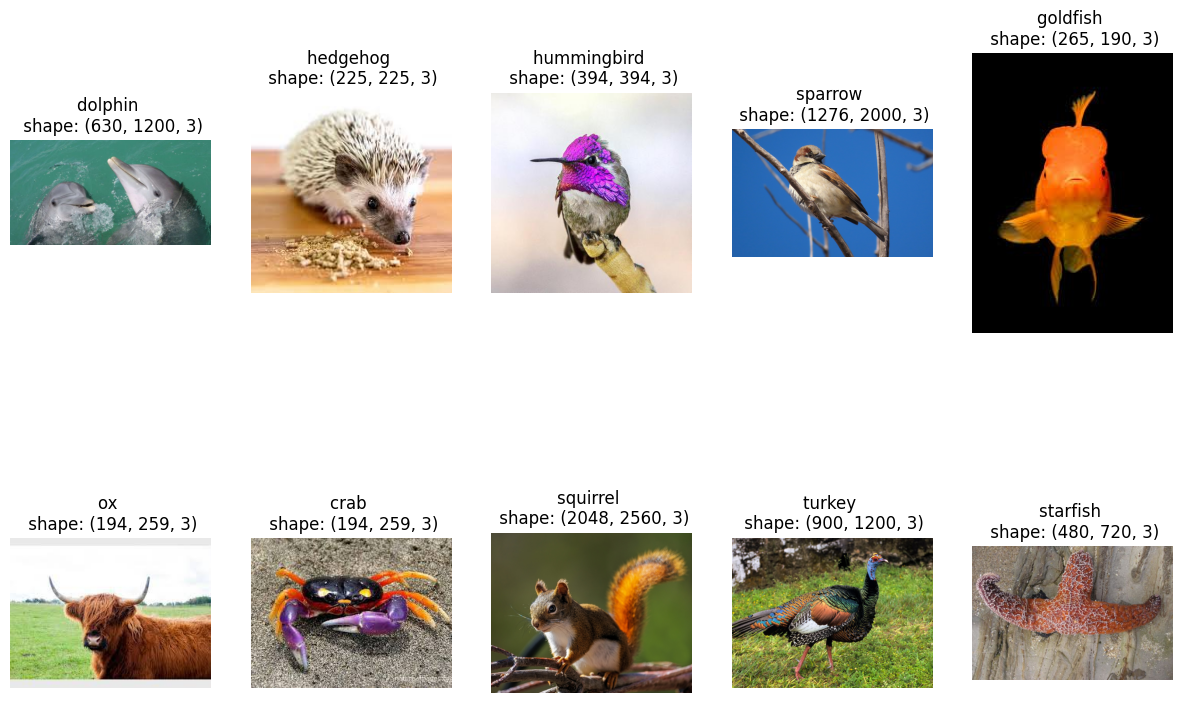

In [30]:
import cv2
import random

# Shuffle classes for diverse visualization
random.shuffle(classes)

# Visualize some sample images from the dataset
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes[:10]):
    class_path = os.path.join(dataset_path, class_name)

    try:
        img_name = random.choice(os.listdir(class_path))  # Pick a random image
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)  # Read with OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f'{class_name} \n shape: {img.shape}')
        plt.axis('off')

    except Exception as e:
        print(f"⚠️ Error loading image from {class_name}: {e}")

plt.show()